## Identification Strategy

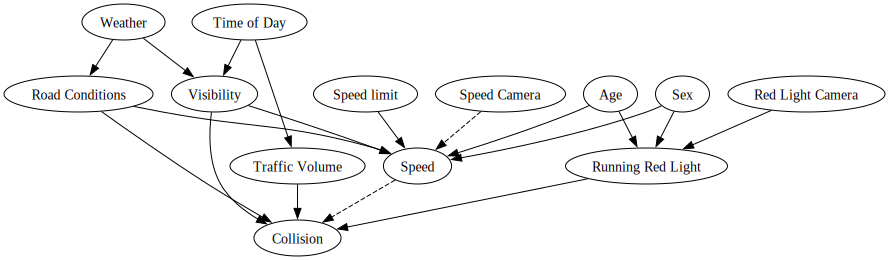

In [54]:
#This notebook details the empirical analysis conducted for this research
#The purpose of this research is to examine the casual effect of speed cameras on the number of collisions in intersections in the lower mainland of British Columbia
from graphviz import Digraph
g = Digraph()
g.edge('Weather', 'Road Conditions')
g.edge('Weather', 'Visibility')
g.edge('Time of Day', 'Visibility')
g.edge('Time of Day', 'Traffic Volume')
g.edge('Visibility', 'Speed')
g.edge('Speed limit', 'Speed')
g.edge('Age', 'Speed')
g.edge('Sex', 'Speed')
g.edge('Age', 'Running Red Light')
g.edge('Sex', 'Running Red Light')
g.edge('Traffic Volume', 'Collision')
g.edge('Running Red Light', 'Collision')
g.edge('Speed', 'Collision',style="dashed")
g.edge('Visibility', 'Collision')
g.edge('Road Conditions', 'Collision')
g.edge('Road Conditions', 'Speed')
g.edge('Red Light Camera', 'Running Red Light')
g.edge('Speed Camera', 'Speed',style="dashed")


g

#A broad DAG of the problem at hand is shown below. Many factors play in to whether a colission occurs, but the central path we are interested in is between spedd cameras and colissions, that is perfectly mediated by speed. 
# In other words, the only way in which speed cameras can reduce colissions is by ry reducing the speed of road users.
#This DAG can be simplified in a number of ways
#In this model, because only data from the lower mainland is used, factors related to weather can largely be ignored, as they are similar across the region.
#Additionally as the data at hand is provided on an annual basis, the time of day factor is not relevant either
#The methodology in this project also assumes that road quality and speed are unchanged over the period, which means that road conditions and speed limits can be ignored
#Additionall, sex and age can be combined into a single variable, demographics.

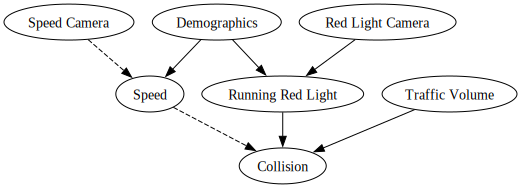

In [55]:
g = Digraph()
g.edge('Demographics', 'Speed')
g.edge('Demographics', 'Running Red Light')
g.edge('Traffic Volume', 'Collision')
g.edge('Running Red Light', 'Collision')
g.edge('Speed', 'Collision',style="dashed")
g.edge('Red Light Camera', 'Running Red Light')
g.edge('Speed Camera', 'Speed',style="dashed")


g

#In this simplified DAG, the causal paths of interest are more easily identified. 
#However, there is reason to expand this DAG again to include additional factors that may have changed during the study period.
#The study period takes place from 2018-2022, which includes the affect of the Covid-19 pandemic. 
#The covid pandemic had widespread affects on traffic patterns, and will enter into the DAG above traffic volume
#Additionally, it may be that the introduction of speed cameras caused a change in people's driving behavior.
#Drivers that chose to speed may choose to take alternate routes, which could cause a shift of colissions from one treated intersection to an adjacent untreated intersection.

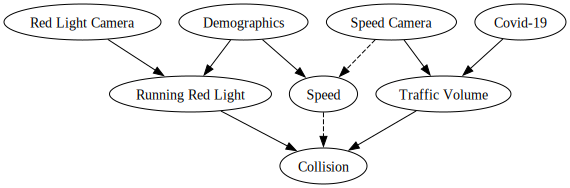

In [56]:
g = Digraph()
g.edge('Demographics', 'Speed')
g.edge('Demographics', 'Running Red Light')
g.edge('Traffic Volume', 'Collision')
g.edge('Running Red Light', 'Collision')
g.edge('Speed', 'Collision',style="dashed")
g.edge('Red Light Camera', 'Running Red Light')
g.edge('Speed Camera', 'Speed',style="dashed")
g.edge('Covid-19', 'Traffic Volume')
g.edge('Speed Camera', 'Traffic Volume')


g

#In this pilot research project I undertake some measures to try and control for the effect of covid on traffic patterns, but am unable to address the spillover effect, leaving room for futher research.

In [57]:
import pandas as pd

#Read in the processed dataframe for analysis
df=pd.read_csv("data/dataset.csv")
df.head()

#The data frame contains colissions at intersections broken up into "Casualty", where someone was injured, and "PDO", meaning property damage only. A total columnn sums them.
#Different types of colissions are broken out, as the effect of the speed cameras amy have heterogenous effects across types of colissions.
#For example, cameras may reduce the rate of high-speed colissions, reducing the number of casualties, but may caus drivers to brake eratically and cause a higher freqeuency of lower speed PDO colissions.
#Other columns include the municipality that each intersection is in, as well as the year that the data is from, ranging from 2018-2022. 
# In this data the pre-treatment period was 2018-2019, with the treatment taking place at the start of 2020.
#Additional columns include the ratio of accidents in each intersection as a fraction of total accidents on each category in the lower mainland for a given year
#Finally, two dummies include an indicator for whether the location was in the treatment group (speed cameras), and whether it had a redlight camera.
#All intersections with automatic speed cameras also have redlight cameras.
#There are 32 treated intersections and 2039 other intersections, each with 5 years of crash data.


#The fractional data is used as a possible control for covid. For it to be an appropriate control, it must be that traffic patterns changed uniformly across all intersections during covid, a bold assumption.

,Location,Casualty,PDO,Total,Municipality,2018,2019,2020,2021,2022,PDOFrac,CasualtyFrac,TotalFrac,Treatment,Redlight
0,1 AVE & 176 ST,1.0,4.0,5.0,SURREY,1,0,0,0,0,0.000025,0.000021,0.000024,0,0
1,1 AVE & 176 ST,0.0,0.0,0.0,SURREY,0,0,0,1,0,0.000000,0.000000,0.000000,0,0
2,1 AVE & 176 ST,1.0,1.0,2.0,SURREY,0,0,1,0,0,0.000009,0.000033,0.000014,0,0
3,1 AVE & 176 ST,3.0,12.0,15.0,SURREY,0,1,0,0,0,0.000080,0.000065,0.000076,0,0
4,1 AVE & 176 ST,1.0,3.0,4.0,SURREY,0,0,0,0,1,0.000020,0.000028,0.000022,0,0


In [58]:
#Define redlights and treatment as lists containing only the locations that contain redlights and and treatment, respectively
#There are 111 redlight cameras, including the 32 speed cameras
redlight = df.loc[df['Redlight'] == 1, 'Location'].unique().tolist()
treatment = df.loc[df['Treatment'] == 1, 'Location'].unique().tolist()



## Matching

In [59]:
#Because selection into treatment was non-random (heavy traffic or dangerous intersections received the treatment) must perform matching to create suitable control group

#This code chunk details the creation of a pivoted data frame thta only includes the years 2018 and 2019 for use in matching
#Creating new data frame for matching purposes
#Matching will be completed for both absolute values and relative for the purpose of two different regressions

#Don't include total beacause of collinearity
df_pivoted = df.pivot_table(index='Location', values=['PDO', 'Casualty','PDOFrac','CasualtyFrac'], aggfunc='sum', fill_value=0, columns=['2018','2019'])

# Flatten MultiIndex columns and create new column names
df_pivoted.columns = [f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col for col in df_pivoted.columns]


# Resetting index to make 'location' a regular column
df_pivoted.reset_index(inplace=True)

#Renaming columns - bug in code above creates one extra column, but I am unable to resolve at this time
new_column_names = ['Location', 'drop', 'Casualty_2019','Casualty_2018','drop','CasualtyFrac_2019','CasualtyFrac_2018','drop','PDO_2019','PDO_2018','drop','PDOFrac_2019','PDOFrac_2018']

df_pivoted.columns = new_column_names
df_pivoted.drop(columns=['drop'], inplace=True)

# Add columns for differences between 2019 and 2018 for both absolute and fractional
df_pivoted['PDODif'] = df_pivoted['PDO_2019']-df_pivoted['PDO_2018']
df_pivoted['CasualtyDif'] = df_pivoted['Casualty_2019']-df_pivoted['Casualty_2018']

df_pivoted['PDOFracDif'] = df_pivoted['PDOFrac_2019']-df_pivoted['PDOFrac_2018']
df_pivoted['CasualtyFracDif'] = df_pivoted['CasualtyFrac_2019']-df_pivoted['CasualtyFrac_2018']

#Readding municipality, redlight, and treatment
#For municipalities
location_municipality_dict = df.groupby('Location')['Municipality'].first().to_dict()

df_pivoted['Municipality'] = 0  # Initialize 'Municipality' to 0 for all rows
df_pivoted['Municipality'] = df_pivoted['Location'].map(location_municipality_dict)


df_pivoted['Redlight'] = 0  # Initialize 'Redlight' to 0 for all rows
df_pivoted['Redlight'][df_pivoted['Location'].isin(redlight)] = 1

df_pivoted['Treatment'] = 0  # Initialize 'Treatment' to 0 for all rows
df_pivoted['Treatment'][df_pivoted['Location'].isin(treatment)] = 1

# #Create dummy column for municipality and drop original municipality column
df_dummies = pd.get_dummies(df_pivoted['Municipality'])

df_pivoted = pd.concat([df_pivoted, df_dummies], axis=1)
df_pivoted.drop(columns=['Municipality'], inplace=True)

df_pivoted

C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\1425141933.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pivoted['Redlight'][df_pivoted['Location'].isin(redlight)] = 1
C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\1425141933.

,Location,Casualty_2019,Casualty_2018,CasualtyFrac_2019,CasualtyFrac_2018,PDO_2019,PDO_2018,PDOFrac_2019,PDOFrac_2018,PDODif,...,COQUITLAM,DELTA,LANGLEY,MAPLE RIDGE,NORTH VANCOUVER,PITT MEADOWS,PORT COQUITLAM,RICHMOND,SURREY,VANCOUVER
0,1 AVE & 176 ST,3.0,1.0,0.000065,0.000021,12.0,4.0,0.000080,0.000025,8.0,...,False,False,False,False,False,False,False,False,True,False
1,100 AVE & 120 ST & SCOTT RD,4.0,2.0,0.000087,0.000042,6.0,6.0,0.000040,0.000038,0.0,...,False,False,False,False,False,False,False,False,True,False
2,100 AVE & 132 ST,13.0,13.0,0.000283,0.000271,7.0,11.0,0.000046,0.000069,-4.0,...,False,False,False,False,False,False,False,False,True,False
3,100 AVE & 140 ST,28.0,10.0,0.000609,0.000208,25.0,16.0,0.000166,0.000101,9.0,...,False,False,False,False,False,False,False,False,True,False
4,100 AVE & 144 ST,8.0,5.0,0.000174,0.000104,4.0,2.0,0.000027,0.000013,2.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,W 41ST AVE & YEW ST,4.0,2.0,0.000087,0.000042,21.0,21.0,0.000139,0.000132,0.0,...,False,False,False,False,False,False,False,False,False,True
2067,W 4TH AVE & YEW ST,6.0,0.0,0.000131,0.000000,13.0,20.0,0.000086,0.000126,-7.0,...,False,False,False,False,False,False,False,False,False,True
2068,W BROADWAY & WILLOW ST,8.0,5.0,0.000174,0.000104,24.0,20.0,0.000159,0.000126,4.0,...,False,False,False,False,False,False,False,False,False,True
2069,W BROADWAY & YEW ST,2.0,3.0,0.000044,0.000062,6.0,6.0,0.000040,0.000038,0.0,...,False,False,False,False,False,False,False,False,False,True


In [60]:
#This section uses a logistic regression model to peform propensity score matching to create the control group

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures#Perofrm matching - drop location and treatment from the matching data frame

#Drop all columns with absolute number of collissions - want to match based on trend, which is difference
#'PDO_2018','PDO_2019','Casualty_2018','Casualty_2019'
#,'CasualtyFrac_2018','CasualtyFrac_2019','PDOFrac_2018','PDOFrac_2019'
df_matching_abs = df_pivoted.drop(columns=['Location','Treatment','CasualtyFrac_2018','CasualtyFrac_2019','PDOFrac_2018','PDOFrac_2019','PDOFracDif','CasualtyFracDif'])
df_matching_rel = df_pivoted.drop(columns=['Location','Treatment','PDO_2018','PDO_2019','Casualty_2018','Casualty_2019','PDODif','CasualtyDif'])

#Create polynomial feature data frame for both the matching data frames (interaction term and polynomial terms)
poly = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
df_poly_abs = poly.fit_transform(df_matching_abs)
df_poly_rel = poly.fit_transform(df_matching_rel)


#Run logistic regression for cross validation to be used in the propensity score matching
logistic = LogisticRegressionCV(penalty='l2', dual=False)
logistic.fit(df_poly_abs, df_pivoted['Treatment'])


# calculate propensity score and add it to the original data frame as a new column
pred_prob = logistic.predict_proba(df_poly_abs)

#Add propensity scores to the data frame
df_pivoted['Propensity_Score_Absolute'] = pred_prob[:, 1]


logistic = LogisticRegressionCV(penalty='l2', dual=False)
logistic.fit(df_poly_rel, df_pivoted['Treatment'])

# calculate propensity score and add it to the original data frame as a new column
pred_prob = logistic.predict_proba(df_poly_rel)

#Add propensity scores to the data frame
df_pivoted['Propensity_Score_Relative'] = pred_prob[:, 1]


df_pivoted.head()



c:\Users\seamu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\seamu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,Location,Casualty_2019,Casualty_2018,CasualtyFrac_2019,CasualtyFrac_2018,PDO_2019,PDO_2018,PDOFrac_2019,PDOFrac_2018,PDODif,...,LANGLEY,MAPLE RIDGE,NORTH VANCOUVER,PITT MEADOWS,PORT COQUITLAM,RICHMOND,SURREY,VANCOUVER,Propensity_Score_Absolute,Propensity_Score_Relative
0,1 AVE & 176 ST,3.0,1.0,0.000065,0.000021,12.0,4.0,0.000080,0.000025,8.0,...,False,False,False,False,False,False,True,False,0.387516,0.015449
1,100 AVE & 120 ST & SCOTT RD,4.0,2.0,0.000087,0.000042,6.0,6.0,0.000040,0.000038,0.0,...,False,False,False,False,False,False,True,False,0.426984,0.015449
2,100 AVE & 132 ST,13.0,13.0,0.000283,0.000271,7.0,11.0,0.000046,0.000069,-4.0,...,False,False,False,False,False,False,True,False,0.144237,0.015449
3,100 AVE & 140 ST,28.0,10.0,0.000609,0.000208,25.0,16.0,0.000166,0.000101,9.0,...,False,False,False,False,False,False,True,False,0.005838,0.015449
4,100 AVE & 144 ST,8.0,5.0,0.000174,0.000104,4.0,2.0,0.000027,0.000013,2.0,...,False,False,False,False,False,False,True,False,0.430577,0.015449


In [61]:
#Selecting control group based on matching results
#Threshold of 0.30 chosen for absolute as it gives a sizeable control group. Larger thresholds lead to rapid loss of units (At 0.4 only 3 control units are included). At 0.30, 270 control units are included, meaning the treated group, at 32 units, is roughly 10% of the sample
selected_locations_abs = df_pivoted.loc[(df_pivoted['Treatment'] == 0) & (df_pivoted['Propensity_Score_Absolute'] > 0.3), 'Location'].tolist()
print(f"The number of control group observations included is {len(selected_locations_abs)}")


#Propensity score matching fails for relative quantities.
print(f"The maximum propensity score found for relative matching is {round(df_pivoted['Propensity_Score_Relative'].max(),3)}")
#Below code not used as matching failed
# selected_locations_rel = df_pivoted.loc[(df_pivoted['Treatment'] == 0) & (df_pivoted['Propensity_Score_Relative'] > 0.02), 'Location'].tolist()



#Now filter df to only include the treatment group and this new subset of the remaining observations as the control group
df_filtered = df[df['Location'].isin(selected_locations_abs+treatment)]
#No filtering for relative amounts as matching was very poor



The number of control group observations included is 786
The maximum propensity score found for relative matching is 0.016


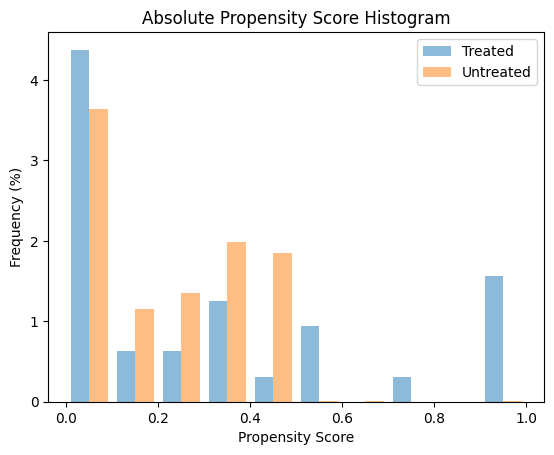

In [62]:
#Drawing histogram of matches to evaluate quality

hist_treat = df_pivoted[df_pivoted['Treatment'] == 1]
hist_untreat  = df_pivoted[df_pivoted['Treatment'] == 0]

plt.hist([hist_treat['Propensity_Score_Absolute'], hist_untreat['Propensity_Score_Absolute']], alpha=0.5, label=['Treated', 'Untreated'], density=True)

plt.xlabel('Propensity Score')
plt.ylabel('Frequency (%)')
plt.title('Absolute Propensity Score Histogram')
plt.legend()


#Histogram shows very poor matching, as seen in the final scatter

## Preparing data for Dif-In-Dif OLS

In [63]:
#This section computes 3 regression models for the absolute number of colissions. One for PDO, Casualty and Total colissions, respectively.
#To perform the regression, must add  another column that takes 1 only for the treated group in years that they were treated (2020,2021,2022)
#The reason for this is to perform a difference-in-differnce regression, leveraging the parallel trend in the pre-treatment period to estimate the treatment effect in all post-treatment years

def new_column(row):
    if row['Treatment'] == 1 and (row['2020'] == 1 or row['2021'] == 1 or row['2022'] == 1):
        return 1
    else:
        return 0
    
df_filtered['Treated'] = df_filtered.apply(new_column, axis = 1)


C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\750464684.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Treated'] = df_filtered.apply(new_column, axis = 1)


## Absolute Number of Crashes - Regressions - Dif-In-Dif

In [64]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
# latex_table = model.summary()

#Renaming columns for years to have Y in them as the smf.ols function will not take them as integers
df_reg = df_filtered.rename(columns={'2018': 'Y2018','2019': 'Y2019','2020': 'Y2020','2021': 'Y2021','2022': 'Y2022'})

#Creating the initial regression for PDO colissions
PDO = smf.ols("PDO ~ Treatment + Y2019 + Y2020 + Y2021 + Y2022 + Y2020:Treated + Y2021:Treated + Y2022:Treated", data=df_reg).fit()
print("PDO Results:\n",PDO.summary().tables[1].as_latex_tabular(),"\n")

#Repeat for casualty and total
Casualty = smf.ols("Casualty ~ Treatment + Y2019 + Y2020 + Y2021 + Y2022 + Y2020:Treated + Y2021:Treated + Y2022:Treated", data=df_reg).fit()
print("Casualty Results:\n",Casualty.summary().tables[1].as_latex_tabular(),"\n")

Total = smf.ols("Total ~ Treatment + Y2019 + Y2020 + Y2021 + Y2022 + Y2020:Treated + Y2021:Treated + Y2022:Treated", data=df_reg).fit()
print("Total Results:\n",Total.summary().tables[1].as_latex_tabular(),"\n")



PDO Results:
 \begin{center}
\begin{tabular}{lcccccc}
\toprule
                       & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{Intercept}     &       6.1293  &        0.263     &    23.268  &         0.000        &        5.613    &        6.646     \\
\textbf{Treatment}     &      42.4123  &        0.951     &    44.593  &         0.000        &       40.548    &       44.277     \\
\textbf{Y2019}         &      -0.2396  &        0.369     &    -0.650  &         0.516        &       -0.963    &        0.483     \\
\textbf{Y2020}         &      -1.2642  &        0.374     &    -3.377  &         0.001        &       -1.998    &       -0.530     \\
\textbf{Y2021}         &       0.3592  &        0.374     &     0.959  &         0.337        &       -0.375    &        1.093     \\
\textbf{Y2022}         &       1.8185  &        0.374     &     4.857  &         0.000        &        1.084    &        2.55

In the above regressions, the treatment effects are significant in all years, for all types of crashes, except for PDO in 2022. 

C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\127446413.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_UB[i] = treatment[i+2]+se[i+6]*1.96
C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\127446413.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_LB[i] = treatment[i+2]-se[i+6]*1.96


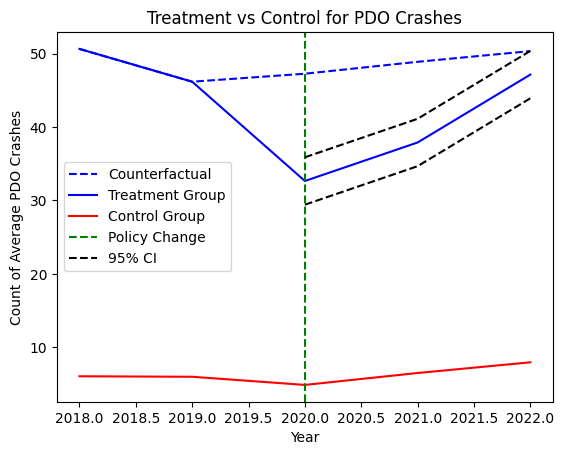

In [65]:
#Graphing results to visualise with 95% confidence intervals shown.

import matplotlib.pyplot as plt
import numpy as np


df_control = df_reg[df_reg['Treatment']==0]
df_treatment = df_reg[df_reg['Treatment']==1]

years = [2018,2019,2020,2021,2022]
#Initialize treatment and control lists
treatment = [0,0,0,0,0]
control = [0,0,0,0,0]
trend = [0,0,0,0,0]


#For PDO
#Compute SE for use in confidence interval plotting
se = PDO.bse


for i in range(5):
    treatment[i] = df_treatment.loc[df_treatment['Y'+str(2018+i)] == 1, 'PDO'].mean()
    control[i] = df_control.loc[df_control['Y'+str(2018+i)] == 1, 'PDO'].mean()

delta = (treatment[0]-control[0]+treatment[1]-control[1])/2

for i in range(3):
    trend[i] = treatment[i]

for i in range (2,5):
    trend[i] = control[i]+delta

plt.plot(years, trend, label='Counterfactual', color = 'blue',  linestyle='--')
plt.plot(years, treatment, label='Treatment Group', color = 'blue',  linestyle='-')
plt.plot(years, control, label='Control Group', color = 'red',  linestyle='-')
plt.axvline(x=2020, color='green', linestyle='--', label='Policy Change')


se = PDO.bse
years_treated = [2020,2021,2022]
CI_UB = [0,0,0]
CI_LB = [0,0,0]
for i in range(3):
    CI_UB[i] = treatment[i+2]+se[i+6]*1.96
    CI_LB[i] = treatment[i+2]-se[i+6]*1.96
#Compute CI lower and upper bounds by adding and subtracting 1.96 standard * the standard error from the observed average

plt.plot(years_treated, CI_UB, label='95% CI', color = 'black',  linestyle='--')
plt.plot(years_treated, CI_LB, color = 'black',  linestyle='--')


# Add labels and a title
plt.xlabel('Year')
plt.ylabel('Count of Average PDO Crashes')
plt.title('Treatment vs Control for PDO Crashes')
plt.legend()

C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\3540031089.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_UB[i] = treatment[i+2]+se[i+6]*1.96
C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\3540031089.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_LB[i] = treatment[i+2]-se[i+6]*1.96


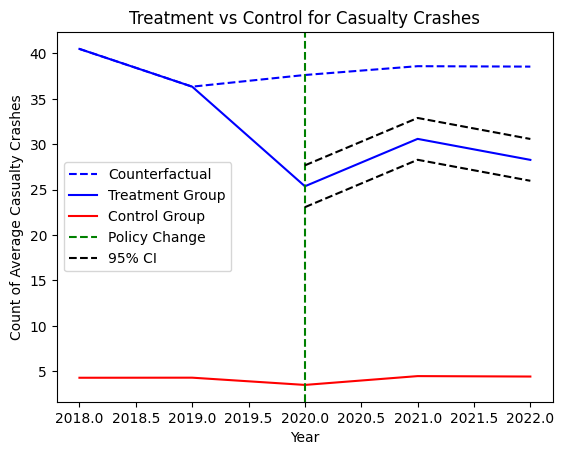

In [66]:
#For Casualty
#Compute SE for use in confidence interval plotting
se = Casualty.bse


for i in range(5):
    treatment[i] = df_treatment.loc[df_treatment['Y'+str(2018+i)] == 1, 'Casualty'].mean()
    control[i] = df_control.loc[df_control['Y'+str(2018+i)] == 1, 'Casualty'].mean()

delta = (treatment[0]-control[0]+treatment[1]-control[1])/2

for i in range(3):
    trend[i] = treatment[i]

for i in range (2,5):
    trend[i] = control[i]+delta

plt.plot(years, trend, label='Counterfactual', color = 'blue',  linestyle='--')
plt.plot(years, treatment, label='Treatment Group', color = 'blue',  linestyle='-')
plt.plot(years, control, label='Control Group', color = 'red',  linestyle='-')
plt.axvline(x=2020, color='green', linestyle='--', label='Policy Change')


for i in range(3):
    CI_UB[i] = treatment[i+2]+se[i+6]*1.96
    CI_LB[i] = treatment[i+2]-se[i+6]*1.96
#Compute CI lower and upper bounds by adding and subtracting 1.96 standard * the standard error from the observed average

plt.plot(years_treated, CI_UB, label='95% CI', color = 'black',  linestyle='--')
plt.plot(years_treated, CI_LB, color = 'black',  linestyle='--')


# Add labels and a title
plt.xlabel('Year')
plt.ylabel('Count of Average Casualty Crashes')
plt.title('Treatment vs Control for Casualty Crashes')
plt.legend()

C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\3375354120.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_UB[i] = treatment[i+2]+se[i+6]*1.96
C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\3375354120.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_LB[i] = treatment[i+2]-se[i+6]*1.96


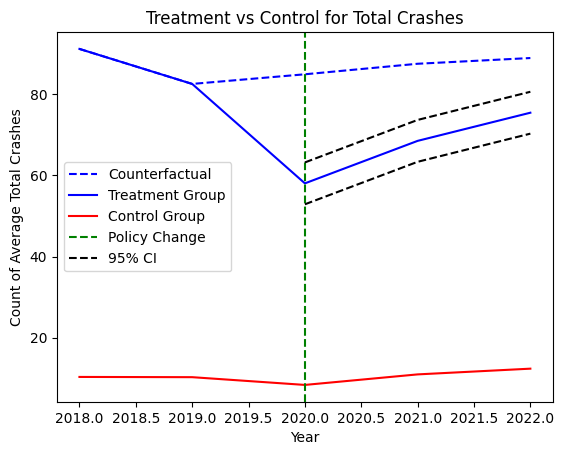

In [67]:
#For Total Colissions
#Compute SE for use in confidence interval plotting
se = Total.bse


for i in range(5):
    treatment[i] = df_treatment.loc[df_treatment['Y'+str(2018+i)] == 1, 'Total'].mean()
    control[i] = df_control.loc[df_control['Y'+str(2018+i)] == 1, 'Total'].mean()

delta = (treatment[0]-control[0]+treatment[1]-control[1])/2

for i in range(3):
    trend[i] = treatment[i]

for i in range (2,5):
    trend[i] = control[i]+delta

plt.plot(years, trend, label='Counterfactual', color = 'blue',  linestyle='--')
plt.plot(years, treatment, label='Treatment Group', color = 'blue',  linestyle='-')
plt.plot(years, control, label='Control Group', color = 'red',  linestyle='-')
plt.axvline(x=2020, color='green', linestyle='--', label='Policy Change')


for i in range(3):
    CI_UB[i] = treatment[i+2]+se[i+6]*1.96
    CI_LB[i] = treatment[i+2]-se[i+6]*1.96
#Compute CI lower and upper bounds by adding and subtracting 1.96 standard * the standard error from the observed average

plt.plot(years_treated, CI_UB, label='95% CI', color = 'black',  linestyle='--')
plt.plot(years_treated, CI_LB, color = 'black',  linestyle='--')


# Add labels and a title
plt.xlabel('Year')
plt.ylabel('Count of Average Total Crashes')
plt.title('Treatment vs Control for Total Crashes')
plt.legend()

## Relative Accidents - Covid Control

In [68]:
#Creating the initial regression for PDO colissions
#This time using the fractional level of accidents
#Use same filtering as for absolute matching

PDOFrac = smf.ols("PDOFrac ~ Treatment + Y2019 + Y2020 + Y2021 + Y2022 + Y2020:Treated + Y2021:Treated + Y2022:Treated", data=df_reg).fit()
print("Fractional PDO Results:\n",PDOFrac.summary().tables[1].as_latex_tabular(),"\n")

#Repeat for casualty and total
CasualtyFrac = smf.ols("CasualtyFrac ~ Treatment + Y2019 + Y2020 + Y2021 + Y2022 + Y2020:Treated + Y2021:Treated + Y2022:Treated", data=df_reg).fit()
print("Fractional Casualty Results:\n",CasualtyFrac.summary().tables[1].as_latex_tabular(),"\n")

TotalFrac = smf.ols("TotalFrac ~ Treatment + Y2019 + Y2020 + Y2021 + Y2022 + Y2020:Treated + Y2021:Treated + Y2022:Treated", data=df_reg).fit()
print("Fractional Total Results:\n",TotalFrac.summary().tables[1].as_latex_tabular(),"\n")

Fractional PDO Results:
 \begin{center}
\begin{tabular}{lcccccc}
\toprule
                       & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{Intercept}     &    3.829e-05  &     1.87e-06     &    20.527  &         0.000        &     3.46e-05    &     4.19e-05     \\
\textbf{Treatment}     &       0.0003  &     6.74e-06     &    40.667  &         0.000        &        0.000    &        0.000     \\
\textbf{Y2019}         &    1.135e-06  &     2.61e-06     &     0.435  &         0.664        &    -3.99e-06    &     6.26e-06     \\
\textbf{Y2020}         &    6.341e-06  &     2.65e-06     &     2.392  &         0.017        &     1.14e-06    &     1.15e-05     \\
\textbf{Y2021}         &    1.137e-05  &     2.65e-06     &     4.287  &         0.000        &     6.17e-06    &     1.66e-05     \\
\textbf{Y2022}         &     1.48e-05  &     2.65e-06     &     5.582  &         0.000        &      9.6e-06    & 

C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\2021440981.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_UB[i] = treatment[i+2]+se[i+6]*1.96
C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\2021440981.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_LB[i] = treatment[i+2]-se[i+6]*1.96


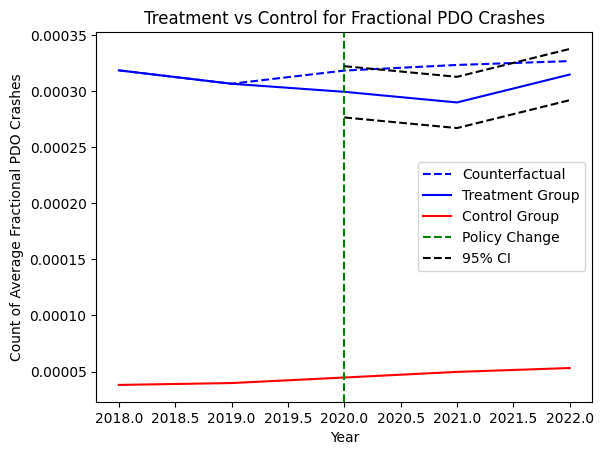

In [69]:
#For PDO
#Compute SE for use in confidence interval plotting
se = PDOFrac.bse

for i in range(5):
    treatment[i] = df_treatment.loc[df_treatment['Y'+str(2018+i)] == 1, 'PDOFrac'].mean()
    control[i] = df_control.loc[df_control['Y'+str(2018+i)] == 1, 'PDOFrac'].mean()

delta = (treatment[0]-control[0]+treatment[1]-control[1])/2

for i in range(3):
    trend[i] = treatment[i]

for i in range (2,5):
    trend[i] = control[i]+delta

plt.plot(years, trend, label='Counterfactual', color = 'blue',  linestyle='--')
plt.plot(years, treatment, label='Treatment Group', color = 'blue',  linestyle='-')
plt.plot(years, control, label='Control Group', color = 'red',  linestyle='-')
plt.axvline(x=2020, color='green', linestyle='--', label='Policy Change')


for i in range(3):
    CI_UB[i] = treatment[i+2]+se[i+6]*1.96
    CI_LB[i] = treatment[i+2]-se[i+6]*1.96
#Compute CI lower and upper bounds by adding and subtracting 1.96 standard * the standard error from the observed average

plt.plot(years_treated, CI_UB, label='95% CI', color = 'black',  linestyle='--')
plt.plot(years_treated, CI_LB, color = 'black',  linestyle='--')


# Add labels and a title
plt.xlabel('Year')
plt.ylabel('Count of Average Fractional PDO Crashes')
plt.title('Treatment vs Control for Fractional PDO Crashes')
plt.legend()

C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\4224308478.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_UB[i] = treatment[i+2]+se[i+6]*1.96
C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\4224308478.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_LB[i] = treatment[i+2]-se[i+6]*1.96


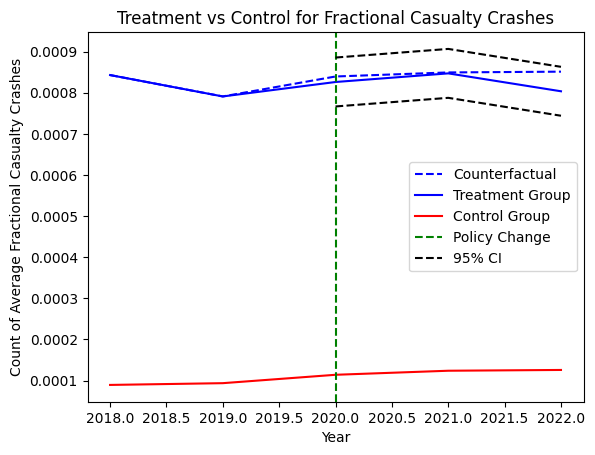

In [70]:
#For Casualty
#Compute SE for use in confidence interval plotting
se = CasualtyFrac.bse

for i in range(5):
    treatment[i] = df_treatment.loc[df_treatment['Y'+str(2018+i)] == 1, 'CasualtyFrac'].mean()
    control[i] = df_control.loc[df_control['Y'+str(2018+i)] == 1, 'CasualtyFrac'].mean()

delta = (treatment[0]-control[0]+treatment[1]-control[1])/2

for i in range(3):
    trend[i] = treatment[i]

for i in range (2,5):
    trend[i] = control[i]+delta

plt.plot(years, trend, label='Counterfactual', color = 'blue',  linestyle='--')
plt.plot(years, treatment, label='Treatment Group', color = 'blue',  linestyle='-')
plt.plot(years, control, label='Control Group', color = 'red',  linestyle='-')
plt.axvline(x=2020, color='green', linestyle='--', label='Policy Change')


for i in range(3):
    CI_UB[i] = treatment[i+2]+se[i+6]*1.96
    CI_LB[i] = treatment[i+2]-se[i+6]*1.96
#Compute CI lower and upper bounds by adding and subtracting 1.96 standard * the standard error from the observed average

plt.plot(years_treated, CI_UB, label='95% CI', color = 'black',  linestyle='--')
plt.plot(years_treated, CI_LB, color = 'black',  linestyle='--')


# Add labels and a title
plt.xlabel('Year')
plt.ylabel('Count of Average Fractional Casualty Crashes')
plt.title('Treatment vs Control for Fractional Casualty Crashes')
plt.legend()

C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\2154298972.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_UB[i] = treatment[i+2]+se[i+6]*1.96
C:\Users\seamu\AppData\Local\Temp\ipykernel_25896\2154298972.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CI_LB[i] = treatment[i+2]-se[i+6]*1.96


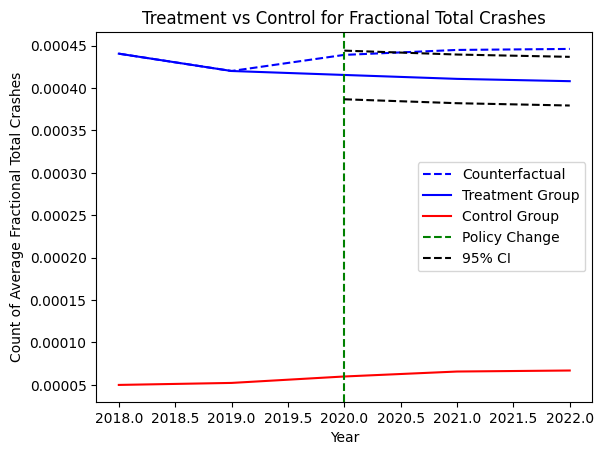

In [71]:
#For Casualty
#Compute SE for use in confidence interval plotting
se = TotalFrac.bse

for i in range(5):
    treatment[i] = df_treatment.loc[df_treatment['Y'+str(2018+i)] == 1, 'TotalFrac'].mean()
    control[i] = df_control.loc[df_control['Y'+str(2018+i)] == 1, 'TotalFrac'].mean()

delta = (treatment[0]-control[0]+treatment[1]-control[1])/2

for i in range(3):
    trend[i] = treatment[i]

for i in range (2,5):
    trend[i] = control[i]+delta

plt.plot(years, trend, label='Counterfactual', color = 'blue',  linestyle='--')
plt.plot(years, treatment, label='Treatment Group', color = 'blue',  linestyle='-')
plt.plot(years, control, label='Control Group', color = 'red',  linestyle='-')
plt.axvline(x=2020, color='green', linestyle='--', label='Policy Change')


for i in range(3):
    CI_UB[i] = treatment[i+2]+se[i+6]*1.96
    CI_LB[i] = treatment[i+2]-se[i+6]*1.96
#Compute CI lower and upper bounds by adding and subtracting 1.96 standard * the standard error from the observed average

plt.plot(years_treated, CI_UB, label='95% CI', color = 'black',  linestyle='--')
plt.plot(years_treated, CI_LB, color = 'black',  linestyle='--')


# Add labels and a title
plt.xlabel('Year')
plt.ylabel('Count of Average Fractional Total Crashes')
plt.title('Treatment vs Control for Fractional Total Crashes')
plt.legend()